In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,),)])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 2070 with Max-Q Design'

In [3]:
trainset = datasets.FashionMNIST('data', download=False, train=True, transform=transform)
testset = datasets.FashionMNIST('data', download=False, train=False, transform=transform)

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    # define forward function
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        # don't need softmax here since we'll use cross-entropy as activation.

        return t

net = Network()
net.to(device)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
losses = []

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 40 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    40] loss: 1.825
[1,    80] loss: 0.863
[1,   120] loss: 0.701
[1,   160] loss: 0.665
[1,   200] loss: 0.617
[2,    40] loss: 0.554
[2,    80] loss: 0.548
[2,   120] loss: 0.546
[2,   160] loss: 0.511
[2,   200] loss: 0.480
[3,    40] loss: 0.479
[3,    80] loss: 0.463
[3,   120] loss: 0.463
[3,   160] loss: 0.452
[3,   200] loss: 0.419
[4,    40] loss: 0.418
[4,    80] loss: 0.416
[4,   120] loss: 0.419
[4,   160] loss: 0.385
[4,   200] loss: 0.383
[5,    40] loss: 0.386
[5,    80] loss: 0.379
[5,   120] loss: 0.376
[5,   160] loss: 0.373
[5,   200] loss: 0.370
[6,    40] loss: 0.355
[6,    80] loss: 0.350
[6,   120] loss: 0.356
[6,   160] loss: 0.347
[6,   200] loss: 0.354
[7,    40] loss: 0.337
[7,    80] loss: 0.328
[7,   120] loss: 0.338
[7,   160] loss: 0.350
[7,   200] loss: 0.321
[8,    40] loss: 0.332
[8,    80] loss: 0.322
[8,   120] loss: 0.325
[8,   160] loss: 0.319
[8,   200] loss: 0.316
[9,    40] loss: 0.316
[9,    80] loss: 0.300
[9,   120] loss: 0.301
[9,   160] 

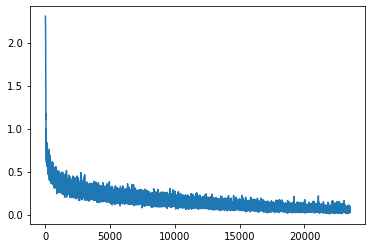

In [10]:
import matplotlib.pyplot as plt

plt.plot(losses);

In [9]:
loss

tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward0>)